In [1]:
#load csv file into a pandas dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy import stats

conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results_01.db')
c = conn.cursor()

## Results

In [4]:
# query sum of number of frames from all videos in database
c.execute('SELECT SUM(total_frames) FROM VideoStatistics')
total_frames = c.fetchone()[0]
total_frames

19023571

In [5]:
frames_with_detections_query = """
WITH FramesWithDetections AS (
    -- First get unique frames with detections for each class and video
    SELECT 
        v.id,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class = 1.0 THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class = 0.0 THEN 1 ELSE 0 END) as has_child,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_adult_face,
        MAX(CASE WHEN d.object_class = 2.0 THEN 1 ELSE 0 END) as has_child_face,
        MAX(CASE WHEN d.object_class = 5.0 THEN 1 ELSE 0 END) as has_book,
        MAX(CASE WHEN d.object_class = 6.0 THEN 1 ELSE 0 END) as has_toy,
        MAX(CASE WHEN d.object_class = 7.0 THEN 1 ELSE 0 END) as has_kitchenware,
        MAX(CASE WHEN d.object_class = 8.0 THEN 1 ELSE 0 END) as has_screen,
        MAX(CASE WHEN d.object_class = 9.0 THEN 1 ELSE 0 END) as has_food,
        MAX(CASE WHEN d.object_class = 10.0 THEN 1 ELSE 0 END) as has_other_object
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    GROUP BY v.id, v.video_id, d.frame_number
),
TotalFramesPerChild AS (
    -- Calculate total frames per child ID
    SELECT 
        v.id,
        SUM(vs.total_frames) as total_frames
    FROM Videos v
    JOIN VideoStatistics vs ON v.video_id = vs.video_id
    GROUP BY v.id
)
-- Then aggregate detections by child ID
SELECT 
    f.id,
    COUNT(DISTINCT f.video_id) as video_count,
    t.total_frames,
    SUM(f.has_adult) as frames_with_adult,
    SUM(f.has_child) as frames_with_child,
    SUM(f.has_adult_face) as frames_with_adult_face,
    SUM(f.has_child_face) as frames_with_child_face,
    SUM(f.has_book) as frames_with_book,
    SUM(f.has_toy) as frames_with_toy,
    SUM(f.has_kitchenware) as frames_with_kitchenware,
    SUM(f.has_screen) as frames_with_screen,
    SUM(f.has_food) as frames_with_food,
    SUM(f.has_other_object) as frames_with_other_object
FROM FramesWithDetections f
JOIN TotalFramesPerChild t ON f.id = t.id
JOIN VideoStatistics vs ON f.video_id = vs.video_id
GROUP BY f.id, t.total_frames
ORDER BY f.id;
"""

# Execute query and create DataFrame
frames_with_detections = pd.read_sql(frames_with_detections_query, conn)


# Calculate percentages
for col in frames_with_detections.columns[3:]:  # Skip id, video_count, and total_frames
    frames_with_detections[f'{col}_percent'] = (
        frames_with_detections[col] / frames_with_detections['total_frames'] * 100
    ).round(2)

# Display results
display(frames_with_detections)

,id,video_count,total_frames,frames_with_adult,frames_with_child,frames_with_adult_face,frames_with_child_face,frames_with_book,frames_with_toy,frames_with_kitchenware,...,frames_with_adult_percent,frames_with_child_percent,frames_with_adult_face_percent,frames_with_child_face_percent,frames_with_book_percent,frames_with_toy_percent,frames_with_kitchenware_percent,frames_with_screen_percent,frames_with_food_percent,frames_with_other_object_percent
0,254922,8,363585,6731,4320,4534,1753,690,1508,106,...,1.85,1.19,1.25,0.48,0.19,0.41,0.03,0.00,0.00,0.46
1,255237,6,282993,5405,15208,1570,6359,1165,7373,50,...,1.91,5.37,0.55,2.25,0.41,2.61,0.02,0.02,0.12,1.05
2,255695,4,68763,2165,2357,780,1008,5,881,630,...,3.15,3.43,1.13,1.47,0.01,1.28,0.92,0.00,0.00,0.47
3,255706,2,72922,3693,2122,1178,1359,379,1557,458,...,5.06,2.91,1.62,1.86,0.52,2.14,0.63,0.00,0.00,0.25
4,255944,5,138006,3224,4767,849,2661,2067,1244,244,...,2.34,3.45,0.62,1.93,1.50,0.90,0.18,0.00,0.03,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,271611,7,286457,2972,2895,2210,232,1005,3994,471,...,1.04,1.01,0.77,0.08,0.35,1.39,0.16,0.01,0.06,0.96
70,271700,6,200637,9361,2115,5093,1233,736,1244,130,...,4.67,1.05,2.54,0.61,0.37,0.62,0.06,0.02,0.04,1.06
71,272475,4,171070,5154,1768,1888,868,1211,676,169,...,3.01,1.03,1.10,0.51,0.71,0.40,0.10,0.01,0.02,1.17
72,273855,6,303755,6960,1994,2302,656,588,1060,74,...,2.29,0.66,0.76,0.22,0.19,0.35,0.02,0.01,0.01,0.47


#### Get adult presence vs. child presence over different age groups 

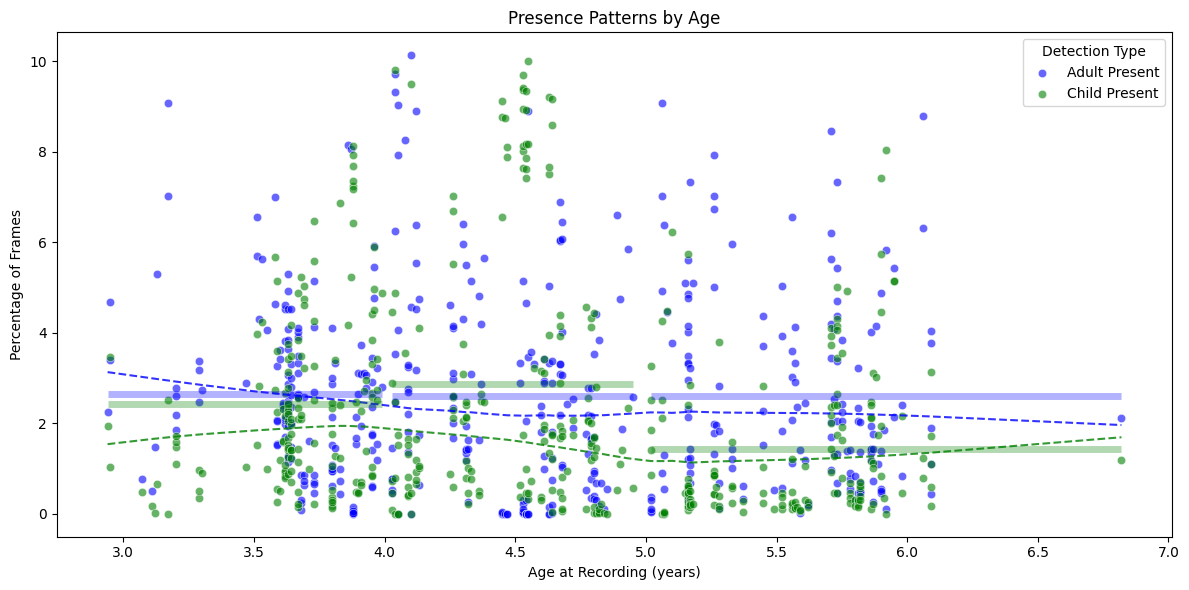


Summary Statistics by Age Group:

Age Group 3 (age range: 2.94-3.99):
Adult Present: 2.64% (±1.77)
Child Present: 2.42% (±1.91)
Number of videos: 143

Age Group 4 (age range: 4.03-4.95):
Adult Present: 2.61% (±2.39)
Child Present: 2.87% (±2.97)
Number of videos: 158

Age Group 5 (age range: 5.02-6.82):
Adult Present: 2.60% (±2.13)
Child Present: 1.43% (±1.65)
Number of videos: 151


In [22]:
presence_query = """
WITH UniqueFrames AS (
    SELECT 
        v.id as child_id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class IN (1.0, 3.0) THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class IN (0.0, 2.0) THEN 1 ELSE 0 END) as has_child
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.age_at_recording IS NOT NULL
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
),
FrameCounts AS (
    SELECT 
        UniqueFrames.child_id,
        UniqueFrames.age_at_recording,  -- Specify table
        UniqueFrames.video_id,
        v2.total_frames,
        COUNT(DISTINCT frame_number) as frames_with_detections,
        SUM(has_adult) as frames_with_adult,
        SUM(has_child) as frames_with_child
    FROM UniqueFrames
    JOIN VideoStatistics v2 ON UniqueFrames.video_id = v2.video_id
    GROUP BY UniqueFrames.child_id, UniqueFrames.age_at_recording, UniqueFrames.video_id, v2.total_frames
)
SELECT 
    child_id,
    age_at_recording,
    video_id,
    SUM(total_frames) as total_frames,
    SUM(frames_with_adult) as frames_with_adult,
    SUM(frames_with_child) as frames_with_child,
    ROUND(SUM(frames_with_adult) * 100.0 / SUM(total_frames), 2) as adult_percent,
    ROUND(SUM(frames_with_child) * 100.0 / SUM(total_frames), 2) as child_percent
FROM FrameCounts
GROUP BY child_id, age_at_recording, video_id
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
presence_data = pd.read_sql(presence_query, conn)

# Add age groups
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

presence_data['age_group'] = presence_data['age_at_recording'].apply(assign_age_group)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot adult and child percentages
sns.scatterplot(data=presence_data, 
                x='age_at_recording', 
                y='adult_percent',
                color='blue',
                alpha=0.6,
                label='Adult Present')

sns.scatterplot(data=presence_data, 
                x='age_at_recording', 
                y='child_percent',
                color='green',
                alpha=0.6,
                label='Child Present')

# Add LOWESS smoothing instead of linear regression
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS for adult percentage
adult_smooth = lowess(presence_data['adult_percent'], 
                     presence_data['age_at_recording'],
                     frac=0.6)
plt.plot(adult_smooth[:, 0], adult_smooth[:, 1], 
         color='blue', linestyle='--', alpha=0.8)

# LOWESS for child percentage
child_smooth = lowess(presence_data['child_percent'], 
                     presence_data['age_at_recording'],
                     frac=0.6)
plt.plot(child_smooth[:, 0], child_smooth[:, 1], 
         color='green', linestyle='--', alpha=0.8)

# Add mean lines for age groups
for age_group in sorted(presence_data['age_group'].unique()):
    group_data = presence_data[presence_data['age_group'] == age_group]
    
    # Adult means
    adult_mean = group_data['adult_percent'].mean()
    age_min = group_data['age_at_recording'].min()
    age_max = group_data['age_at_recording'].max()
    plt.hlines(y=adult_mean, xmin=age_min, xmax=age_max, 
               colors='blue', linestyles='-', alpha=0.3, linewidth=5)
    
    # Child means
    child_mean = group_data['child_percent'].mean()
    plt.hlines(y=child_mean, xmin=age_min, xmax=age_max, 
               colors='green', linestyles='-', alpha=0.3, linewidth=5)

plt.title('Presence Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames')
plt.legend(title='Detection Type')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/presence_patterns_lowess.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print statistical summary
print("\nSummary Statistics by Age Group:")
for age in sorted(presence_data['age_group'].unique()):
    age_data = presence_data[presence_data['age_group'] == age]
    print(f"\nAge Group {age} (age range: {age_data['age_at_recording'].min():.2f}-{age_data['age_at_recording'].max():.2f}):")
    print(f"Adult Present: {age_data['adult_percent'].mean():.2f}% (±{age_data['adult_percent'].std():.2f})")
    print(f"Child Present: {age_data['child_percent'].mean():.2f}% (±{age_data['child_percent'].std():.2f})")
    print(f"Number of videos: {len(age_data)}")

#### Number of frames with one adult/child, two adults/children etc

In [26]:
presence_count_query = """
WITH FaceOverlaps AS (
    SELECT 
        d1.video_id,
        d1.frame_number,
        d1.detection_id,  -- Changed from d1.id
        d1.object_class,
        CASE 
            WHEN d1.object_class IN (2.0, 3.0) THEN 1
            ELSE 2
        END as detection_priority,
        CASE WHEN EXISTS (
            SELECT 1 FROM Detections d2
            WHERE d2.video_id = d1.video_id
            AND d2.frame_number = d1.frame_number
            AND d2.object_class = d1.object_class
            AND d2.detection_id < d1.detection_id  -- Changed from d2.id
            AND (
                GREATEST(0, 
                    LEAST(d1.x_max, d2.x_max) - GREATEST(d1.x_min, d2.x_min)
                ) * 
                GREATEST(0, 
                    LEAST(d1.y_max, d2.y_max) - GREATEST(d1.y_min, d2.y_min)
                )
            ) / (
                ((d1.x_max - d1.x_min) * (d1.y_max - d1.y_min)) +
                ((d2.x_max - d2.x_min) * (d2.y_max - d2.y_min)) -
                (
                    GREATEST(0, 
                        LEAST(d1.x_max, d2.x_max) - GREATEST(d1.x_min, d2.x_min)
                    ) * 
                    GREATEST(0, 
                        LEAST(d1.y_max, d2.y_max) - GREATEST(d1.y_min, d2.y_min)
                    )
                )
            ) > 0.5
        ) THEN 1 ELSE 0 END as is_duplicate
    FROM Detections d1
    WHERE d1.object_class IN (0.0, 1.0, 2.0, 3.0)
),
FrameCounts AS (
    -- Count unique detections per frame
    SELECT 
        v.id as child_id,
        v.age_at_recording,
        v.video_id,
        f.frame_number,
        -- Count unique adults (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (3.0) OR (f.object_class = 1.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 3.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as adult_count,
        -- Count unique children (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (2.0) OR (f.object_class = 0.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 2.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as child_count
    FROM Videos v
    JOIN FaceOverlaps f ON v.video_id = f.video_id
    WHERE v.age_at_recording IS NOT NULL
    GROUP BY v.id, v.age_at_recording, v.video_id, f.frame_number
)
SELECT 
    child_id,
    age_at_recording,
    video_id,
    COUNT(DISTINCT frame_number) as total_frames,
    -- Adult counts
    SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_adult,
    SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_adult,
    SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_adult,
    -- Child counts
    SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_child,
    SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_child,
    SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_child,
    -- Percentages
    ROUND(SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_adult_percent,
    ROUND(SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_child_percent
FROM FrameCounts
GROUP BY child_id, age_at_recording, video_id
ORDER BY age_at_recording;
"""
presence_count_data = pd.read_sql(presence_count_query, conn)

def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Add age groups
presence_count_data['age_group'] = presence_count_data['age_at_recording'].apply(assign_age_group)

# Plot adults
colors_adult = {'one_plus': 'darkblue', 'two_plus': 'blue', 'three_plus': 'lightblue'}
for count_type, color in colors_adult.items():
    col = f'{count_type}_adult_percent'
    sns.scatterplot(data=presence_count_data, 
                    x='age_at_recording',
                    y=col,
                    color=color,
                    alpha=0.6,
                    label=f'{count_type.replace("_", " ").title()} Adults',
                    ax=ax1)
    
    # Add LOWESS trend
    smooth = lowess(presence_count_data[col], 
                   presence_count_data['age_at_recording'],
                   frac=0.6)
    ax1.plot(smooth[:, 0], smooth[:, 1], 
             color=color, linestyle='--', alpha=0.8)
    
    # Add mean lines for each age group
    for age_group in [3, 4, 5]:
        group_data = presence_count_data[presence_count_data['age_group'] == age_group]
        mean_val = group_data[col].mean()
        ax1.hlines(y=mean_val,
                  xmin=group_data['age_at_recording'].min(),
                  xmax=group_data['age_at_recording'].max(),
                  colors=color,
                  alpha=0.3,
                  linewidth=5)

ax1.set_title('Adult Presence Patterns')
ax1.set_xlabel('Age at Recording (years)')
ax1.set_ylabel('Percentage of Frames')

# Plot children
colors_child = {'one_plus': 'darkgreen', 'two_plus': 'green', 'three_plus': 'lightgreen'}
for count_type, color in colors_child.items():
    col = f'{count_type}_child_percent'
    sns.scatterplot(data=presence_count_data,
                    x='age_at_recording',
                    y=col,
                    color=color,
                    alpha=0.6,
                    label=f'{count_type.replace("_", " ").title()} Children',
                    ax=ax2)
    
    # Add LOWESS trend
    smooth = lowess(presence_count_data[col],
                   presence_count_data['age_at_recording'],
                   frac=0.6)
    ax2.plot(smooth[:, 0], smooth[:, 1],
             color=color, linestyle='--', alpha=0.8)
    
    # Add mean lines for each age group
    for age_group in [3, 4, 5]:
        group_data = presence_count_data[presence_count_data['age_group'] == age_group]
        mean_val = group_data[col].mean()
        ax2.hlines(y=mean_val,
                  xmin=group_data['age_at_recording'].min(),
                  xmax=group_data['age_at_recording'].max(),
                  colors=color,
                  alpha=0.3,
                  linewidth=5)

ax2.set_title('Child Presence Patterns')
ax2.set_xlabel('Age at Recording (years)')
ax2.set_ylabel('Percentage of Frames')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/presence_count_patterns.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics by age group
summary_stats = presence_count_data.groupby('age_group').agg({
    'one_plus_adult_percent': ['mean', 'std', 'count'],
    'two_plus_adult_percent': ['mean', 'std', 'count'],
    'three_plus_adult_percent': ['mean', 'std', 'count'],
    'one_plus_child_percent': ['mean', 'std', 'count'],
    'two_plus_child_percent': ['mean', 'std', 'count'],
    'three_plus_child_percent': ['mean', 'std', 'count']
}).round(2)

print("\nPresence Count Summary by Age Group:")
print(summary_stats)

DatabaseError: Execution failed on sql '
WITH FaceOverlaps AS (
    SELECT 
        d1.video_id,
        d1.frame_number,
        d1.detection_id,  -- Changed from d1.id
        d1.object_class,
        CASE 
            WHEN d1.object_class IN (2.0, 3.0) THEN 1
            ELSE 2
        END as detection_priority,
        CASE WHEN EXISTS (
            SELECT 1 FROM Detections d2
            WHERE d2.video_id = d1.video_id
            AND d2.frame_number = d1.frame_number
            AND d2.object_class = d1.object_class
            AND d2.detection_id < d1.detection_id  -- Changed from d2.id
            AND (
                GREATEST(0, 
                    LEAST(d1.x_max, d2.x_max) - GREATEST(d1.x_min, d2.x_min)
                ) * 
                GREATEST(0, 
                    LEAST(d1.y_max, d2.y_max) - GREATEST(d1.y_min, d2.y_min)
                )
            ) / (
                ((d1.x_max - d1.x_min) * (d1.y_max - d1.y_min)) +
                ((d2.x_max - d2.x_min) * (d2.y_max - d2.y_min)) -
                (
                    GREATEST(0, 
                        LEAST(d1.x_max, d2.x_max) - GREATEST(d1.x_min, d2.x_min)
                    ) * 
                    GREATEST(0, 
                        LEAST(d1.y_max, d2.y_max) - GREATEST(d1.y_min, d2.y_min)
                    )
                )
            ) > 0.5
        ) THEN 1 ELSE 0 END as is_duplicate
    FROM Detections d1
    WHERE d1.object_class IN (0.0, 1.0, 2.0, 3.0)
),
FrameCounts AS (
    -- Count unique detections per frame
    SELECT 
        v.id as child_id,
        v.age_at_recording,
        v.video_id,
        f.frame_number,
        -- Count unique adults (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (3.0) OR (f.object_class = 1.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 3.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as adult_count,
        -- Count unique children (prioritize faces over bodies)
        COUNT(DISTINCT CASE 
            WHEN (f.object_class IN (2.0) OR (f.object_class = 0.0 AND NOT EXISTS (
                SELECT 1 FROM FaceOverlaps f2 
                WHERE f2.video_id = f.video_id 
                AND f2.frame_number = f.frame_number 
                AND f2.object_class = 2.0
            )))
            AND f.is_duplicate = 0 THEN f.detection_id 
        END) as child_count
    FROM Videos v
    JOIN FaceOverlaps f ON v.video_id = f.video_id
    WHERE v.age_at_recording IS NOT NULL
    GROUP BY v.id, v.age_at_recording, v.video_id, f.frame_number
)
SELECT 
    child_id,
    age_at_recording,
    video_id,
    COUNT(DISTINCT frame_number) as total_frames,
    -- Adult counts
    SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_adult,
    SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_adult,
    SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_adult,
    -- Child counts
    SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) as frames_with_one_plus_child,
    SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) as frames_with_two_plus_child,
    SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) as frames_with_three_plus_child,
    -- Percentages
    ROUND(SUM(CASE WHEN adult_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_adult_percent,
    ROUND(SUM(CASE WHEN adult_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_adult_percent,
    ROUND(SUM(CASE WHEN child_count >= 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as one_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as two_plus_child_percent,
    ROUND(SUM(CASE WHEN child_count >= 3 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT frame_number), 2) as three_plus_child_percent
FROM FrameCounts
GROUP BY child_id, age_at_recording, video_id
ORDER BY age_at_recording;
': no such function: GREATEST

#### Compare percentage of adult faces looking at child vs. child faces looking at child

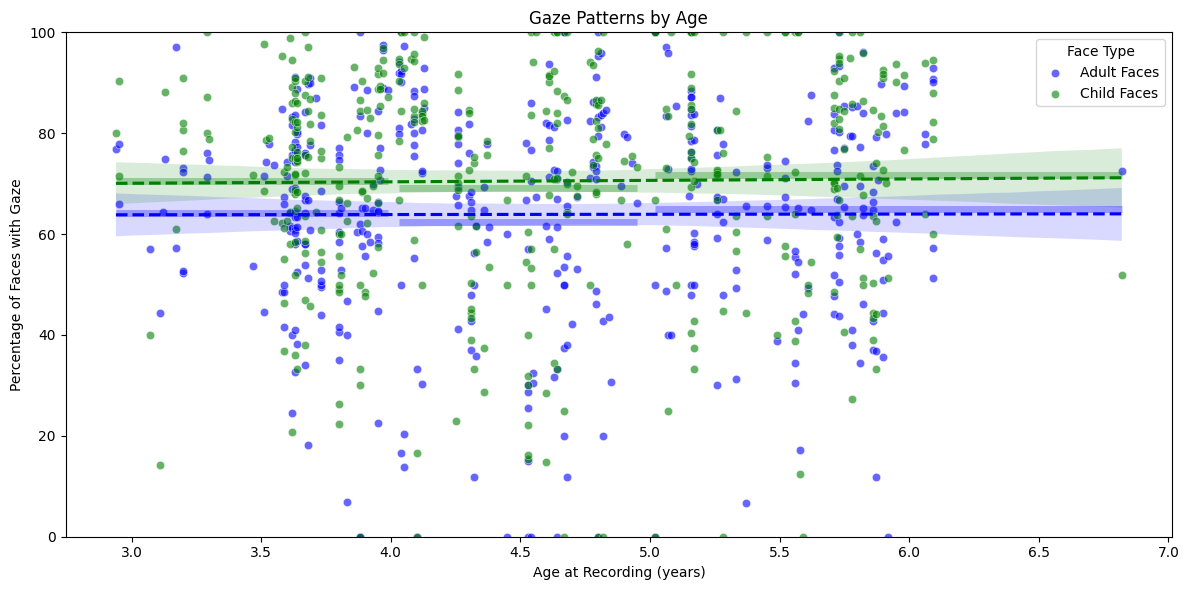


Summary Statistics by Age Group:

Age Group 3 (age range: 2.94-3.99):
Adult Gaze: 64.19% (±18.31)
Child Gaze: 70.61% (±19.15)
Number of videos: 142

Age Group 4 (age range: 4.03-4.95):
Adult Gaze: 62.40% (±25.32)
Child Gaze: 69.23% (±25.39)
Number of videos: 146

Age Group 5 (age range: 5.02-6.82):
Adult Gaze: 65.04% (±20.33)
Child Gaze: 71.68% (±22.87)
Number of videos: 150


In [6]:
gaze_analysis_query = """
SELECT 
    v.id as id,
    v.age_at_recording,
    v.video_id,
    -- Adult gaze counts
    COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END) as total_adult_faces,
    COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1 THEN 1 END) as adult_gazing,
    -- Child gaze counts
    COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END) as total_child_faces,
    COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) as child_gazing,
    -- Calculate percentages
    ROUND(COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1.0 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END), 0), 2) as adult_gaze_percent,
    ROUND(COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END), 0), 2) as child_gaze_percent
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE v.age_at_recording IS NOT NULL
    AND d.object_class IN (2.0, 3.0)  -- Only look at face detections
GROUP BY v.id, v.age_at_recording, v.video_id
ORDER BY v.age_at_recording;
"""
# Execute query and create DataFrame
gaze_patterns = pd.read_sql(gaze_analysis_query, conn)

# Create age groups for statistics (but keep original age_at_recording for plotting)
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Add age group column but keep original age_at_recording for plotting
gaze_patterns['age_group'] = gaze_patterns['age_at_recording'].apply(assign_age_group)

# Create figure
plt.figure(figsize=(12, 6))

# Plot adult gaze percentages
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='adult_gaze_percent',
                color='blue',
                alpha=0.6,
                label='Adult Faces')

# Plot child gaze percentages
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='child_gaze_percent',
                color='green',
                alpha=0.6,
                label='Child Faces')

# Add trend lines with confidence intervals
sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='adult_gaze_percent',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='child_gaze_percent',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

# Add mean lines for age groups
for age_group in sorted(gaze_patterns['age_group'].unique()):
    group_data = gaze_patterns[gaze_patterns['age_group'] == age_group]
    
    # Adult means
    adult_mean = group_data['adult_gaze_percent'].mean()
    age_min = group_data['age_at_recording'].min()
    age_max = group_data['age_at_recording'].max()
    plt.hlines(y=adult_mean, xmin=age_min, xmax=age_max, 
               colors='blue', linestyles='-', alpha=0.3, linewidth=5)
    
    # Child means
    child_mean = group_data['child_gaze_percent'].mean()
    plt.hlines(y=child_mean, xmin=age_min, xmax=age_max, 
               colors='green', linestyles='-', alpha=0.3, linewidth=5)

plt.title('Gaze Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Faces with Gaze')
plt.legend(title='Face Type')

# Set y-axis limits to focus on main data range
plt.ylim(0, min(100, gaze_patterns[['adult_gaze_percent', 'child_gaze_percent']].max().max() * 1.1))

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/gaze_patterns_continuous.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print statistical summary
print("\nSummary Statistics by Age Group:")
for age in sorted(gaze_patterns['age_group'].unique()):
    age_data = gaze_patterns[gaze_patterns['age_group'] == age]
    print(f"\nAge Group {age} (age range: {age_data['age_at_recording'].min():.2f}-{age_data['age_at_recording'].max():.2f}):")
    print(f"Adult Gaze: {age_data['adult_gaze_percent'].mean():.2f}% (±{age_data['adult_gaze_percent'].std():.2f})")
    print(f"Child Gaze: {age_data['child_gaze_percent'].mean():.2f}% (±{age_data['child_gaze_percent'].std():.2f})")
    print(f"Number of videos: {len(age_data)}")

#### Analyse proximity value across age groups and adults vs children

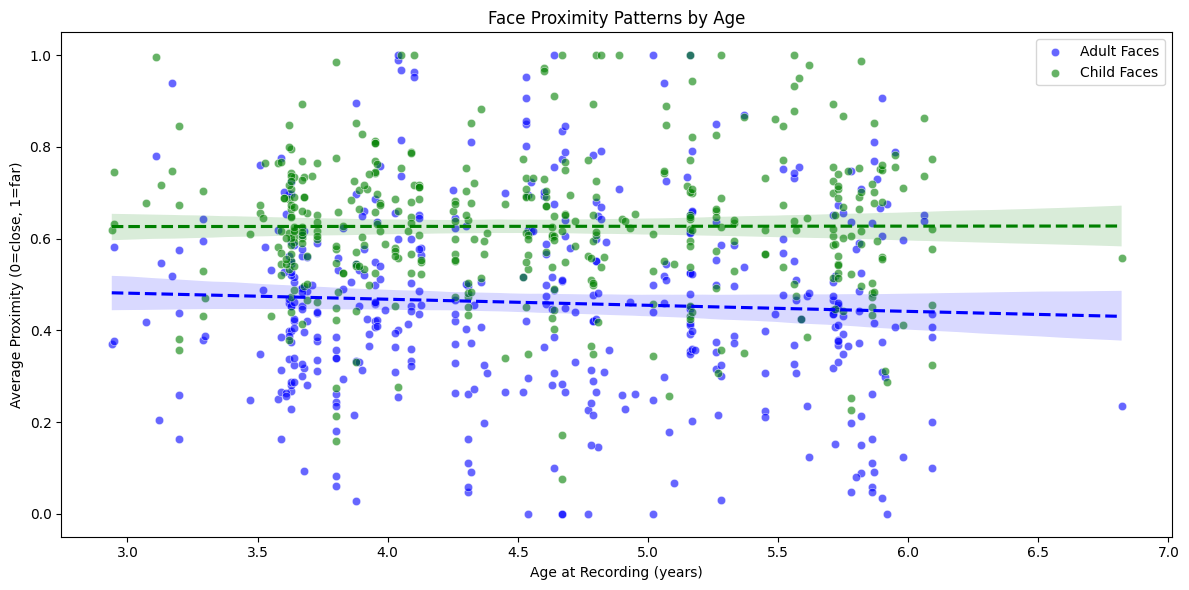


Proximity Pattern Comparison:

Overall Proximity:
Adult mean proximity: 0.451
Child mean proximity: 0.628
t-statistic: -18.662
p-value: 0.0000
Number of valid comparisons: 401


In [25]:
# Query to get proximity data with float values
proximity_query = """
SELECT 
    v.id as id,
    v.age_at_recording,
    v.video_id,
    -- Adult faces (object_class 3)
    COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END) as total_adult_faces,
    AVG(CASE WHEN d.object_class = 3.0 THEN d.proximity END) as avg_adult_proximity,
    -- Child faces (object_class 2)
    COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END) as total_child_faces,
    AVG(CASE WHEN d.object_class = 2.0 THEN d.proximity END) as avg_child_proximity
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE v.age_at_recording IS NOT NULL
    AND d.object_class IN (2.0, 3.0)
    AND d.proximity IS NOT NULL
GROUP BY v.id, v.age_at_recording, v.video_id
"""

# Execute query and create DataFrame
proximity_patterns = pd.read_sql(proximity_query, conn)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot proximity values (0 = close, 1 = far)
sns.scatterplot(data=proximity_patterns, 
                x='age_at_recording', 
                y='avg_adult_proximity',
                color='blue',
                alpha=0.6,
                label='Adult Faces')

sns.scatterplot(data=proximity_patterns, 
                x='age_at_recording', 
                y='avg_child_proximity',
                color='green',
                alpha=0.6,
                label='Child Faces')

# Add trend lines
sns.regplot(data=proximity_patterns,
            x='age_at_recording',
            y='avg_adult_proximity',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=proximity_patterns,
            x='age_at_recording',
            y='avg_child_proximity',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

plt.title('Face Proximity Patterns by Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Average Proximity (0=close, 1=far)')
plt.legend()

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/proximity_patterns_by_age.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison between adult and child proximity
print("\nProximity Pattern Comparison:")
valid_data = proximity_patterns.dropna(subset=['avg_adult_proximity', 'avg_child_proximity'])
if len(valid_data) > 1:
    t_stat, p_value = stats.ttest_rel(
        valid_data['avg_adult_proximity'],
        valid_data['avg_child_proximity']
    )
    print(f"\nOverall Proximity:")
    print(f"Adult mean proximity: {valid_data['avg_adult_proximity'].mean():.3f}")
    print(f"Child mean proximity: {valid_data['avg_child_proximity'].mean():.3f}")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of valid comparisons: {len(valid_data)}")

#### Analyse connection between proximity and gaze relationship

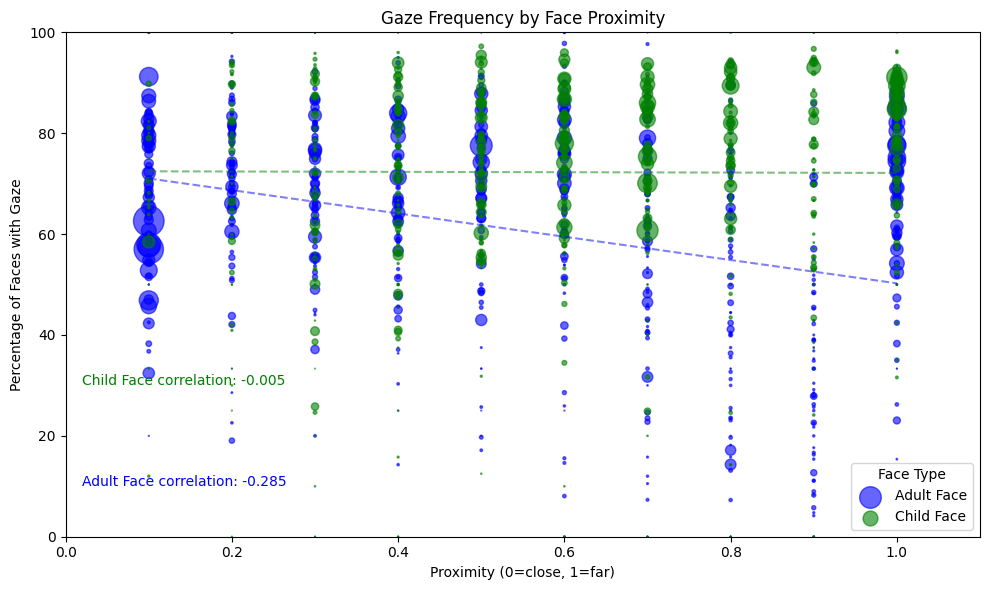


Statistical Analysis of Proximity vs Gaze Relationship:

Adult Face:
Correlation coefficient: -0.285
P-value: 0.0000
Average gaze percentage for close faces (proximity < 0.3): 68.34%
Average gaze percentage for far faces (proximity > 0.7): 49.45%

Child Face:
Correlation coefficient: -0.005
P-value: 0.9073
Average gaze percentage for close faces (proximity < 0.3): 76.44%
Average gaze percentage for far faces (proximity > 0.7): 73.00%


In [31]:
# Query to analyze proximity vs gaze relationship
proximity_gaze_query = """
SELECT 
    v.id as id,
    d.object_class,
    -- Create bins (0-0.1, 0.1-0.2, etc.)
    CASE 
        WHEN d.proximity <= 0.1 THEN 0.1
        WHEN d.proximity <= 0.2 THEN 0.2
        WHEN d.proximity <= 0.3 THEN 0.3
        WHEN d.proximity <= 0.4 THEN 0.4
        WHEN d.proximity <= 0.5 THEN 0.5
        WHEN d.proximity <= 0.6 THEN 0.6
        WHEN d.proximity <= 0.7 THEN 0.7
        WHEN d.proximity <= 0.8 THEN 0.8
        WHEN d.proximity <= 0.9 THEN 0.9
        ELSE 1.0
    END as proximity_bin,
    COUNT(*) as total_faces,
    SUM(CASE WHEN d.gaze_direction = 1 THEN 1 ELSE 0 END) as faces_with_gaze,
    ROUND(SUM(CASE WHEN d.gaze_direction = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as gaze_percent
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE d.object_class IN (2.0, 3.0)
    AND d.proximity IS NOT NULL
    AND d.gaze_direction IS NOT NULL
GROUP BY v.id, d.object_class, proximity_bin
ORDER BY d.object_class, proximity_bin;
"""

# Execute query and create DataFrame
prox_gaze_patterns = pd.read_sql(proximity_gaze_query, conn)

prox_gaze_patterns['object_class'] = prox_gaze_patterns['object_class'].astype(float)
prox_gaze_patterns['face_type'] = prox_gaze_patterns['object_class'].apply(lambda x: 'Child Face' if x == 2.0 else 'Adult Face' if x == 3.0 else None)

# Create single figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each face type
colors = {'Adult Face': 'blue', 'Child Face': 'green'}
for face_type in ['Adult Face', 'Child Face']:
    face_data = prox_gaze_patterns[prox_gaze_patterns['face_type'] == face_type]
    
    if len(face_data) >= 2:
        # Adjust size scaling - divide total_faces by 10 for smaller points
        scatter = ax.scatter(face_data['proximity_bin'],
                           face_data['gaze_percent'],
                           s=face_data['total_faces']/10,  # Reduced size scaling
                           alpha=0.6,
                           c=colors[face_type],
                           label=face_type)
        
        # Add trend line
        z = np.polyfit(face_data['proximity_bin'], face_data['gaze_percent'], 1)
        p = np.poly1d(z)
        ax.plot(face_data['proximity_bin'], 
                p(face_data['proximity_bin']), 
                '--', 
                color=colors[face_type],
                alpha=0.5)
        
        # Add correlation in lower left corner
        corr = face_data['proximity_bin'].corr(face_data['gaze_percent'])
        y_pos = 10 + (20 * (['Adult Face', 'Child Face'].index(face_type)))
        plt.text(0.02, y_pos,
                f'{face_type} correlation: {corr:.3f}',
                color=colors[face_type])

plt.title('Gaze Frequency by Face Proximity')
plt.xlabel('Proximity (0=close, 1=far)')
plt.ylabel('Percentage of Faces with Gaze')
plt.legend(title='Face Type')

# Set axis limits
plt.xlim(0, 1.1)
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/proximity_vs_gaze.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical analysis with data validation
print("\nStatistical Analysis of Proximity vs Gaze Relationship:")
for face_type in ['Adult Face', 'Child Face']:
    face_data = prox_gaze_patterns[prox_gaze_patterns['face_type'] == face_type]
    
    if len(face_data) >= 2:
        # Correlation test
        correlation, p_value = stats.pearsonr(face_data['proximity_bin'], face_data['gaze_percent'])
        
        print(f"\n{face_type}:")
        print(f"Correlation coefficient: {correlation:.3f}")
        print(f"P-value: {p_value:.4f}")
        
        # Calculate averages only if we have data in those ranges
        close_faces = face_data[face_data['proximity_bin'] < 0.3]
        far_faces = face_data[face_data['proximity_bin'] > 0.7]
        
        if len(close_faces) > 0:
            print(f"Average gaze percentage for close faces (proximity < 0.3): "
                  f"{close_faces['gaze_percent'].mean():.2f}%")
        if len(far_faces) > 0:
            print(f"Average gaze percentage for far faces (proximity > 0.7): "
                  f"{far_faces['gaze_percent'].mean():.2f}%")
    else:
        print(f"\n{face_type}: Insufficient data for analysis")


#### Combined object and adult vs. object and child detection

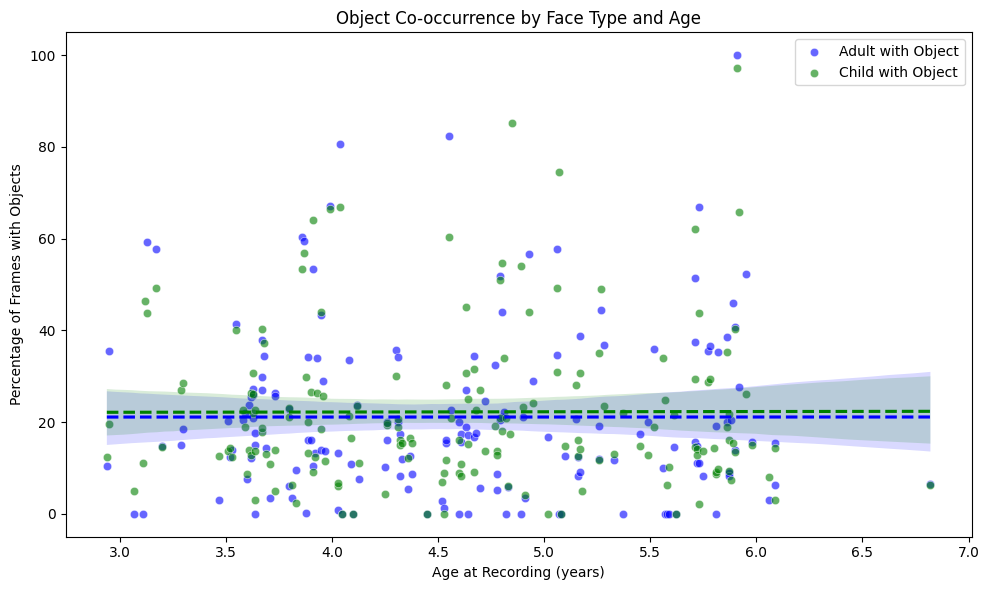


Statistical Comparison:
Adult with object mean: 21.10%
Child with object mean: 21.96%
t-statistic: -0.882
p-value: 0.3793
Number of valid comparisons: 165


In [40]:
object_cooccurrence_query = """
WITH FrameObjects AS (
    SELECT 
        v.id as id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class = 2.0 THEN 1 ELSE 0 END) as has_adult_face,
        MAX(CASE WHEN d.object_class IN (5.0, 6.0, 7.0, 8.0, 9.0, 10.0) THEN 1 ELSE 0 END) as has_object,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_child_face
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
)
SELECT 
    id,
    age_at_recording,
    COUNT(DISTINCT frame_number) as total_frames,
    SUM(has_adult_face) as frames_with_adult,
    SUM(has_child_face) as frames_with_child,
    SUM(CASE WHEN has_adult_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) as adult_object_frames,
    SUM(CASE WHEN has_child_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) as child_object_frames,
    -- Calculate percentages based on frames where faces are present
    ROUND(SUM(CASE WHEN has_adult_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(has_adult_face), 0), 2) as adult_object_percent,
    ROUND(SUM(CASE WHEN has_child_face = 1 AND has_object = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(has_child_face), 0), 2) as child_object_percent
FROM FrameObjects
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
object_patterns = pd.read_sql(object_cooccurrence_query, conn)

# Create visualization
plt.figure(figsize=(10, 6))

# Plot percentages
sns.scatterplot(data=object_patterns, 
                x='age_at_recording', 
                y='adult_object_percent',
                color='blue',
                alpha=0.6,
                label='Adult with Object')

sns.scatterplot(data=object_patterns, 
                x='age_at_recording', 
                y='child_object_percent',
                color='green',
                alpha=0.6,
                label='Child with Object')

# Add trend lines
sns.regplot(data=object_patterns,
            x='age_at_recording',
            y='adult_object_percent',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'})

sns.regplot(data=object_patterns,
            x='age_at_recording',
            y='child_object_percent',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'})

plt.title('Object Co-occurrence by Face Type and Age')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames with Objects')
plt.legend()

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/object_cooccurrence.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
valid_data = object_patterns.dropna(subset=['adult_object_percent', 'child_object_percent'])
if len(valid_data) > 1:
    t_stat, p_value = stats.ttest_rel(
        valid_data['adult_object_percent'],
        valid_data['child_object_percent']
    )
    print("\nStatistical Comparison:")
    print(f"Adult with object mean: {valid_data['adult_object_percent'].mean():.2f}%")
    print(f"Child with object mean: {valid_data['child_object_percent'].mean():.2f}%")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of valid comparisons: {len(valid_data)}")

### Object prevalence

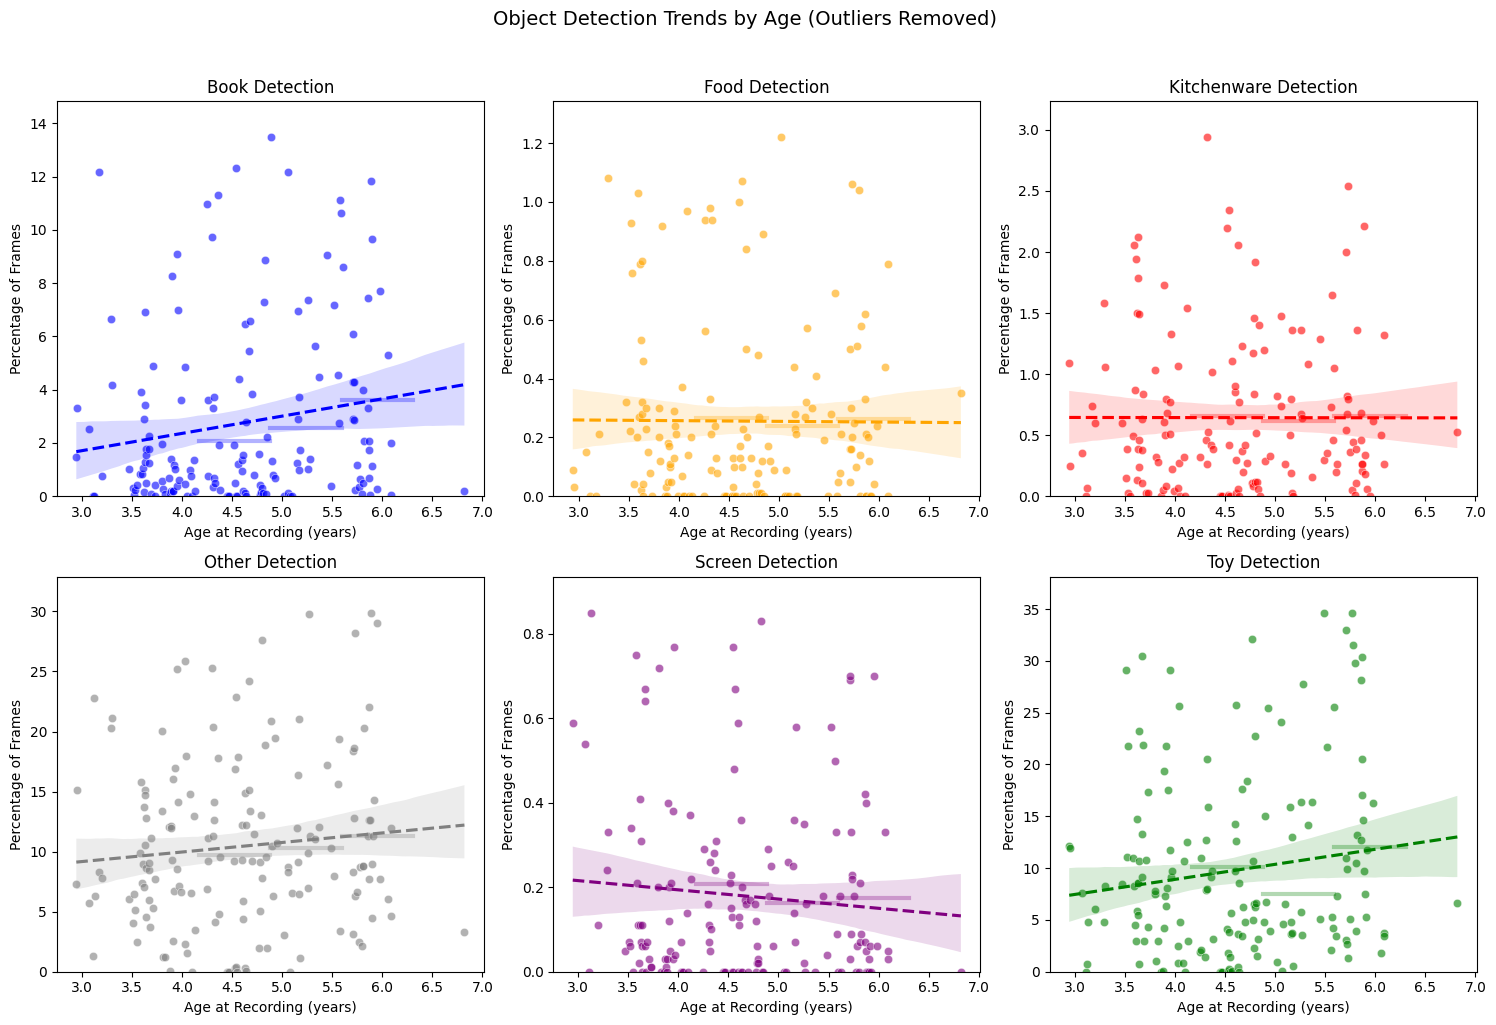


Outliers removed:
book: 16 outliers removed
toy: 10 outliers removed
kitchenware: 21 outliers removed
screen: 17 outliers removed
food: 19 outliers removed
other: 12 outliers removed


In [46]:
object_frequency_query = """
WITH ObjectCounts AS (
    SELECT 
        v.id as id,
        v.age_at_recording,
        v.video_id,
        COUNT(DISTINCT d.frame_number) as total_frames,
        -- Count frames with each object type
        SUM(CASE WHEN d.object_class = 5.0 THEN 1 ELSE 0 END) as book_frames,
        SUM(CASE WHEN d.object_class = 6.0 THEN 1 ELSE 0 END) as toy_frames,
        SUM(CASE WHEN d.object_class = 7.0 THEN 1 ELSE 0 END) as kitchenware_frames,
        SUM(CASE WHEN d.object_class = 8.0 THEN 1 ELSE 0 END) as screen_frames,
        SUM(CASE WHEN d.object_class = 9.0 THEN 1 ELSE 0 END) as food_frames,
        SUM(CASE WHEN d.object_class = 10.0 THEN 1 ELSE 0 END) as other_object_frames
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    GROUP BY v.id, v.age_at_recording, v.video_id
)
SELECT 
    id,
    age_at_recording,
    -- Calculate percentages for each object type
    ROUND(SUM(book_frames) * 100.0 / SUM(total_frames), 2) as book_percent,
    ROUND(SUM(toy_frames) * 100.0 / SUM(total_frames), 2) as toy_percent,
    ROUND(SUM(kitchenware_frames) * 100.0 / SUM(total_frames), 2) as kitchenware_percent,
    ROUND(SUM(screen_frames) * 100.0 / SUM(total_frames), 2) as screen_percent,
    ROUND(SUM(food_frames) * 100.0 / SUM(total_frames), 2) as food_percent,
    ROUND(SUM(other_object_frames) * 100.0 / SUM(total_frames), 2) as other_percent
FROM ObjectCounts
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
object_freq = pd.read_sql(object_frequency_query, conn)

# Define age group assignment function
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    else:
        return 5

# Execute query and create DataFrame
object_freq = pd.read_sql(object_frequency_query, conn)

# Apply age grouping BEFORE melting
object_freq['age_group'] = object_freq['age_at_recording'].apply(assign_age_group)

# Reshape data for better plotting
object_freq_melted = object_freq.melt(
    id_vars=['age_at_recording', 'age_group'],
    value_vars=['book_percent', 'toy_percent', 'kitchenware_percent', 
                'screen_percent', 'food_percent', 'other_percent'],
    var_name='object_type',
    value_name='percentage'
)

# Clean up object type names
object_freq_melted['object_type'] = object_freq_melted['object_type'].str.replace('_percent', '')
def remove_outliers(group):
    Q1 = group['percentage'].quantile(0.25)
    Q3 = group['percentage'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['percentage'] >= lower_bound) & (group['percentage'] <= upper_bound)]

# Remove outliers for each object type
object_freq_cleaned = pd.DataFrame()
for obj_type in object_freq_melted['object_type'].unique():
    obj_data = object_freq_melted[object_freq_melted['object_type'] == obj_type]
    cleaned_data = remove_outliers(obj_data)
    object_freq_cleaned = pd.concat([object_freq_cleaned, cleaned_data])

# Create faceted plot with cleaned data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Object Detection Trends by Age (Outliers Removed)', y=1.02, fontsize=14)

# Colors for consistency
colors = {
    'book': 'blue',
    'toy': 'green',
    'kitchenware': 'red',
    'screen': 'purple',
    'food': 'orange',
    'other': 'gray'
}

# Plot each object type in its own subplot
for (obj_type, data), ax in zip(object_freq_cleaned.groupby('object_type'), axes.flat):
    # Scatter plot
    sns.scatterplot(
        data=data,
        x='age_at_recording',
        y='percentage',
        color=colors[obj_type],
        alpha=0.6,
        ax=ax
    )
    
    # Trend line
    sns.regplot(
        data=data,
        x='age_at_recording',
        y='percentage',
        scatter=False,
        color=colors[obj_type],
        line_kws={'linestyle': '--'},
        ax=ax
    )
    
    # Add mean lines for each age group
    means = data.groupby('age_group')['percentage'].mean()
    for age_group in means.index:
        ax.axhline(y=means[age_group], 
                   xmin=(age_group-1)/6, 
                   xmax=age_group/6, 
                   color=colors[obj_type], 
                   alpha=0.3,
                   linewidth=3)
    
    # Set y-axis limits based on cleaned data
    y_max = data['percentage'].max()
    ax.set_ylim(0, y_max * 1.1)  # Add 10% padding
    
    ax.set_title(f'{obj_type.capitalize()} Detection')
    ax.set_xlabel('Age at Recording (years)')
    ax.set_ylabel('Percentage of Frames')

plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/object_frequency_trends_cleaned.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary of removed outliers
print("\nOutliers removed:")
for obj_type in object_freq_melted['object_type'].unique():
    original_count = len(object_freq_melted[object_freq_melted['object_type'] == obj_type])
    cleaned_count = len(object_freq_cleaned[object_freq_cleaned['object_type'] == obj_type])
    print(f"{obj_type}: {original_count - cleaned_count} outliers removed")

In [ ]:
# Close connection
conn.close()